<a href="https://colab.research.google.com/github/Udinanon/CV-Project-Prototypes/blob/main/Hand_Segmentation_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Needed setup  

In [ ]:
%ls
%cd drive/MyDrive/
%cd 'Colab Notebooks'/faces_datasets/
# move to correct folder

/content/drive/MyDrive/Colab Notebooks/faces_datasets


In [ ]:
# copied from https://towardsdatascience.com/train-an-object-detector-using-tensorflow-2-object-detection-api-in-2021-a4fed450d1b9
# use script to download and "setup" egohands
!git clone https://github.com/aalpatya/detect_hands.git
!cp detect_hands/egohands_dataset_to_csv.py .
!python egohands_dataset_to_csv.py

In [ ]:
# remove useless files
!rm -dr detect_hands/
!rm -f egohands_data.zip
!rm -dr egohands/

rm: cannot remove 'egohands/': No such file or directory


In [ ]:
#unpack the hand_pver_face dataset 
!tar -xvzf hand_over_face_corrected.tar.gz

In [ ]:
#remove dataset file
!rm -f hand_over_face_corrected.tar.gz


In [ ]:
import torchvision
import numpy as np
import torch
from PIL import Image
import os
os.getcwd()


'/content'

In [ ]:
# import Mask RCNN model 
# https://pytorch.org/vision/master/models/mask_rcnn.html

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
import torchvision.transforms as transforms
imsize = 256

loader = transforms.Compose([transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

model(image_loader("images/train/CARDS_LIVINGROOM_T_B_frame_0001.jpg"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[{'boxes': tensor([[2.7205e+02, 2.3700e+00, 1.1100e+03, 4.9810e+02],
          [2.6245e+02, 3.1285e+02, 1.2781e+03, 7.0411e+02],
          [5.1997e+02, 5.5928e+02, 7.8365e+02, 7.1282e+02],
          [3.0721e+02, 1.7092e+02, 3.5941e+02, 1.9122e+02],
          [4.1286e+02, 5.4377e+02, 8.1240e+02, 7.1265e+02],
          [3.0988e+02, 1.7431e+02, 3.6683e+02, 2.0394e+02],
          [6.4490e+01, 1.4096e+02, 2.1217e+02, 2.4528e+02],
          [3.3036e+01, 2.2839e+02, 9.6997e+02, 7.0521e+02],
          [9.8147e+02, 8.5726e-01, 1.2616e+03, 1.6730e+02],
          [4.2602e+01, 2.2800e+02, 2.2274e+02, 3.0599e+02],
          [4.5868e+02, 3.2990e+02, 6.6032e+02, 4.5038e+02],
          [6.9837e+01, 3.9890e+02, 6.8608e+02, 6.8816e+02],
          [3.1269e+02, 1.7301e+02, 4.0436e+02, 1.9469e+02],
          [2.6275e+02, 3.8970e+02, 8.2047e+02, 7.1076e+02],
          [2.7441e+02, 1.7360e+02, 3.8500e+02, 2.0878e+02],
          [5.1389e-01, 2.9701e+02, 7.3273e+01, 3.5774e+02],
          [4.3240e+02, 3.4077e+

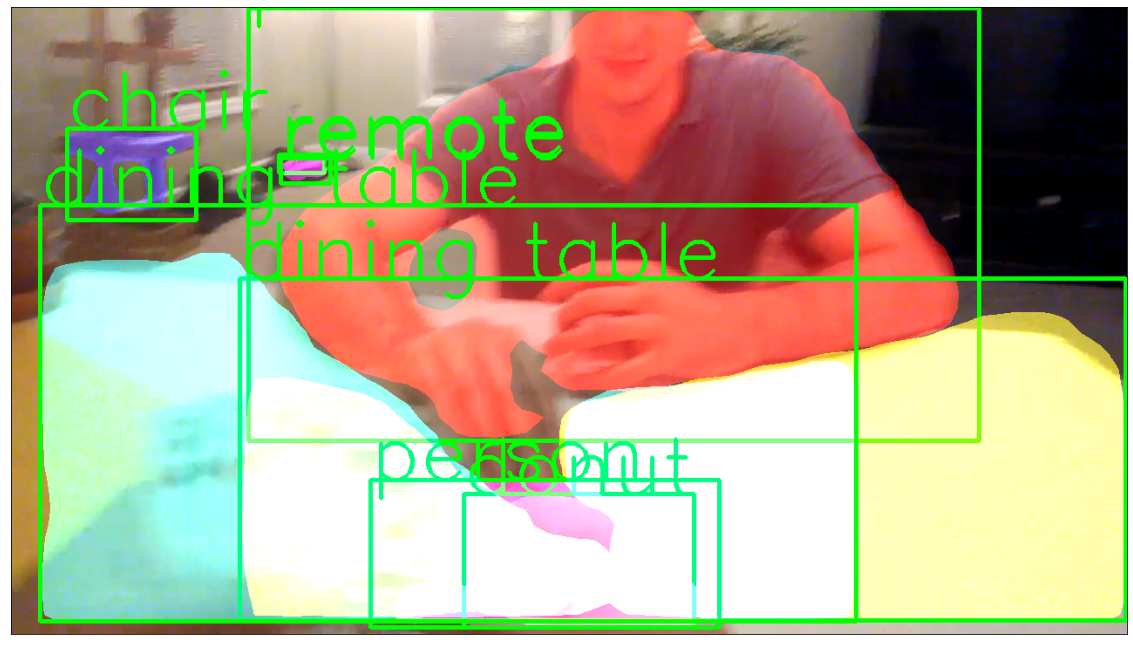

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

import cv2, random
import matplotlib.pyplot as plt

image_path = "images/train/CARDS_LIVINGROOM_T_B_frame_0001.jpg"

def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = transforms.Compose([transforms.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

instance_segmentation_api(image_path)
